# Finding Patterns in Data
## LSI and Scikit-Learn
    Maxwell Nielsen
    Section 001
    10/11/2022

In [1]:
import os
import string
import numpy as np
import sklearn
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

In [2]:
def prob1():
    """Recreate the plot in Figure 1 by performing 
    PCA on the breast cancer dataset.
    Include in the graph title the amount of variance
    captured by the first two principal components."""
    plt.figure(figsize=((10,6)))
    cancer = sklearn.datasets.load_breast_cancer()   #import the data
    X = cancer.data
    y = cancer.target
    
    Y = X - np.mean(X, axis=0)   #preprocess the data
    
    u, e, vt = la.svd(Y)
    y_hat = u[:, :2] @ np.diag(e)[:2, :2]     #calculate the svd in the desired way
    
    malignant = y == 0
    mal_mat = y_hat[malignant]
    ben_mat = y_hat[~malignant]   #get the malignant and benign vals
    
    plt.scatter(mal_mat[:,0], mal_mat[:, 1], label='Malignant', color='red', alpha=.3, s=9)
    plt.scatter(ben_mat[:, 0], ben_mat[:, 1], label='Benign', color='green', alpha=.3, s=9)  #plot the components
    plt.xlabel('First Principle Component')
    plt.ylabel('Second Principle Component')
    
    sum_of_squares = np.sum(e**2)
    var1 = (e[0])**2/sum_of_squares
    var2 = (e[1])**2/sum_of_squares
    var = var1+var2   #calculate the variace captured by the first two components
    
    plt.title('Variance: '+str(var))
    
    plt.legend()
    plt.show()

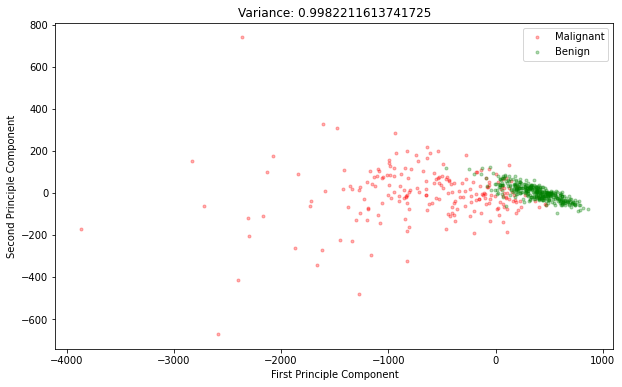

In [3]:
prob1()

## Problem 2
Implement the function similar()

In [4]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components and returns the indices of
    the documents that are the most and least similar to i.
    
    Parameters:
    i index of a document
    Xhat decomposed data
    
    Returns:
    index_min: index of the document most similar to document i
    index_max: index of the document least similar to document i
    """
    vals = []
    n = Xhat.shape[0]    #get the number of rows in Xhat
    x_i = Xhat[i, :]       #get the index row and its norm
    xi_norm = la.norm(x_i)
    for j in range(n):
            vals.append(np.dot(Xhat[j, :], x_i) / (xi_norm*la.norm(Xhat[j,:])))  #find the similarity calculation
            
    max_ind, min_ind = np.argmax(vals), np.argmin(vals)
    
    if max_ind == i:
        vals[i] = np.mean(vals)
    if min_ind == i:                  #adjust the index for skipping i
        vals[i] = np.mean(vals)

        
    return np.argmax(vals), np.argmin(vals)

### Function for Problem 3

In [5]:
def document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [6]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 principal
    components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    X, paths = document_converter()
    speech_index = paths.index(speech)
    
    u, e, vt = spla.svds(X, k=l)
    y_hat = u[:, :l] @ np.diag(e)[:l, :l]     #calculate the svd in the desired way
    
    most_sim, least_sim = similar(speech_index, y_hat)
    
    return paths[most_sim][12:-4], paths[least_sim][12:-4]

In [7]:
#Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

/var/folders/5r/5n4nm5w14254l_1t_2lqx2nh0000gn/T/ipykernel_5217/1507959476.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shape=(len(paths), len(vocab)), dtype=np.float)


('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [8]:
def weighted_document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
    A (sparse matrix, n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab))
    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count
                    
    X, _ = document_converter()   #get the x matrix
    ps = X/np.sum(X, axis=1)    #calculate the p matrix
    g = 1 + np.sum(np.multiply(ps, np.log(ps+1))/np.log(len(paths)), axis=1)   #calculate the g values
    
    return sparse.csr_matrix((np.multiply(g,np.log(X.todense() + 1)))), paths   #calculate A

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [9]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with the
    first 7 principal components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    A, paths = weighted_document_converter()   #get A and the paths 
    from sklearn.decomposition import PCA
    pca = PCA(n_components=l)          #use built in PCA decomposition
    Xhat = pca.fit_transform(A.toarray())
    
    speech_index = paths.index(speech)   #get the index of the speech
    
    most_sim, least_sim = similar(speech_index, Xhat)   #find the most and least similar speeches
    
    return paths[most_sim][12:-4], paths[least_sim][12:-4]

In [10]:
#Run this box after you have completed prob5()
speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

/var/folders/5r/5n4nm5w14254l_1t_2lqx2nh0000gn/T/ipykernel_5217/1507959476.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shape=(len(paths), len(vocab)), dtype=np.float)


('1985-Reagan', '1961-Kennedy')
('1994-Clinton', '1951-Truman')


/var/folders/5r/5n4nm5w14254l_1t_2lqx2nh0000gn/T/ipykernel_5217/1507959476.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shape=(len(paths), len(vocab)), dtype=np.float)


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [17]:
cancer = sklearn.datasets.load_breast_cancer()   #import the data
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)   #Split the data into training and testing sets

#Fit the esimators to training data and predict the test labels
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

#Get precision, recall, and F1 scores all at once
print("Nearest Neighbors: \n", classification_report(y_test, knn_predicted), '\n')
print("Random Forest: \n", classification_report(y_test, rf_predicted), '\n')
print("A random forest is a better choice in this case because we value recall over precision in situations in "
      "which a false positive isn't really a terrible thing. The results of a false negative in cancer treatment "
      "could be quite disastrous.")

Nearest Neighbors: 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        56
           1       0.93      0.94      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143
 

Random Forest: 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.95      0.95      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143
 

A random forest is a better choice in this case because we value recall over precision in situations in which a false positive isn't really a terrible thing. The results of a false negative in cancer treatment could be quite disastrous.


## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [27]:
cancer = sklearn.datasets.load_breast_cancer()   #import the data
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)   #Split the data into training and testing sets
rf = RandomForestClassifier()   #create random forest
param_grid = {
    "n_estimators": [20, 40, 60, 80, 100], 
    "criterion": ["gini", "entropy", "log_loss"],  #test different params
    "max_depth": [5, 10, 15, 20],
}
rf_gs = GridSearchCV(rf, param_grid, scoring='f1', n_jobs=-1)
rf_gs.fit(X_train, y_train)  #create our GridSearch and fit estimators

print(rf_gs.best_params_, rf_gs.best_score_, sep='\n')

bestest = rf_gs.best_estimator_ #utilize best model
prediction = bestest.predict(X_test)  #predict labels for test set
CM = confusion_matrix(y_test, prediction)  #create and display confusion matrix
display(CM)

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 60}
0.9763090848960694


array([[52,  4],
       [ 4, 83]])

## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least .96

In [3]:
cancer = sklearn.datasets.load_breast_cancer()   #import the data
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)   #Split the data into training and testing 
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),             #Create the Pipeline, labeling each step
    ("classifier", KNeighborsClassifier()),
])

#Specify the hyperparameters to test for each step
pipe_param_grid = {
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],    
    "pca__n_components": [2,3,4,5],
    "pca__svd_solver": ['auto', 'full', 'arpack', 'randomized'],
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

#Pass the Pipeline object to the GridSearchCV and fit it to the data
pipe_gs = GridSearchCV(pipe, pipe_param_grid, scoring='f1', n_jobs=-1).fit(X_train, y_train)
print(pipe_gs.best_params_, pipe_gs.best_score_, sep='\n')

{'classifier__algorithm': 'auto', 'classifier__weights': 'uniform', 'pca__n_components': 5, 'pca__svd_solver': 'auto', 'scaler__with_mean': True, 'scaler__with_std': True}
0.969106086904252
